# НТ 8

## Задание
1. Проведите эксперименты, постройте график скорости cходимости сети в зависимости от learning_rate, выберите оптимальное значение.

2. Примените нормализацию данных. Исследуйте скорость сходимости.

3. Измените струтуру сети. Постройте график/таблицу зависимости качества обучения в зависимости от удаления/добавления скрытого слоя, Удаления/добавления нейронов в каждом слое.

4. Исследуйте скорость сходимости сети в зависимости от выбранной функции активации в слоях.
https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity

5. Исследуйте скорость сходимости сети в зависимости от выбранного метода оптимизации.
https://pytorch.org/docs/stable/optim.html

6. Исследуйте скорость сходимости сети в зависимости от начальной инициализации весов.

In [7]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
# Определение устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
def get_df(path='weatherAUS.csv'):
    df = pd.read_csv(path).dropna()
    df['RainToday'] = df['RainToday'].map({'No': 0, 'Yes': 1}).astype(int)
    df['RainTomorrow'] = df['RainTomorrow'].map({'No': 0, 'Yes': 1}).astype(int)
    return df

def convert_X_to_tensor(X, is_scaled):
    return torch.from_numpy(X if is_scaled else X.to_numpy()).float()

def convert_y_to_tensor(y, is_scaled):
    return torch.squeeze(torch.from_numpy(y if is_scaled else y.to_numpy()).float())

def get_X_y_tensor(df, is_scaled=False):
    X = df[['Rainfall', 'Humidity3pm', 'RainToday', 'Pressure9am']]
    y = df[['RainTomorrow']]

    if is_scaled:
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)
        y = scaler.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train = convert_X_to_tensor(X_train, is_scaled).to(device)
    y_train = convert_y_to_tensor(y_train, is_scaled).to(device)
    X_test = convert_X_to_tensor(X_test, is_scaled).to(device)
    y_test = convert_y_to_tensor(y_test, is_scaled).to(device)

    return X_train, X_test, y_train, y_test

In [22]:
# Модель нейронной сети
class Net(nn.Module):
    def __init__(self, n_features, hidden_layers=[8, 4], activation_fn=F.relu):
        super(Net, self).__init__()
        layers = []
        input_size = n_features
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU() if activation_fn == F.relu else activation_fn)
            input_size = hidden_size
        layers.append(nn.Linear(input_size, 1))
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)
    # Подсчет точности
def calculate_accuracy(y_true, y_pred):
    predicted = y_pred.ge(0.5).view(-1)
    return (y_true == predicted).sum().float() / len(y_true)

def calc_by_epochs(X_train, X_test, y_train, y_test, num_epochs, net, optimizer, criterion=nn.BCELoss().to(device)):
    epoch_losses = []
    epoch_accuracies = []
    for epoch in range(num_epochs):
        y_pred = net(X_train).squeeze()
        train_loss = criterion(y_pred, y_train)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            y_test_pred = net(X_test).squeeze()
            test_loss = criterion(y_test_pred, y_test)
            test_acc = calculate_accuracy(y_test, y_test_pred)

            print(f'Epoch {epoch}, Loss: {test_loss.item()}, Accuracy: {test_acc.item()}')
            epoch_losses.append(test_loss.item())
            epoch_accuracies.append(test_acc.item())

    return epoch_losses, epoch_accuracies

def visualize_results(results, title=None):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 строка, 3 столбца
    
    for param, metrics in results.items():
        losses = metrics["losses"]
        accuracies = metrics["accuracies"]
        epochs = range(0, len(losses) * 100, 100)
        
        # Loss plot
        axes[0].plot(epochs, losses, label=f'{param}')
        axes[0].set_title("Loss", fontsize=14)
        axes[0].set_xlabel("Epochs", fontsize=12)
        axes[0].set_ylabel("Loss", fontsize=12)
        axes[0].grid(True, linestyle="--", alpha=0.7)
        axes[0].set_yscale('log')

        # Accuracy plot
        axes[1].plot(epochs, accuracies, label=f'{param}')
        axes[1].set_title("Accuracy", fontsize=14)
        axes[1].set_xlabel("Epochs", fontsize=12)
        axes[1].set_ylabel("Accuracy", fontsize=12)
        axes[1].grid(True, linestyle="--", alpha=0.7)

        # Combined plot
        axes[2].plot(epochs, losses, label=f'Loss ({param})', color='red', alpha=0.7)
        axes[2].plot(epochs, accuracies, label=f'Accuracy ({param})', color='blue', alpha=0.7)
        axes[2].set_title("Loss & Accuracy", fontsize=14)
        axes[2].set_xlabel("Epochs", fontsize=12)
        axes[2].legend()
        axes[2].grid(True, linestyle="--", alpha=0.7)

    for ax in axes:
        ax.legend(fontsize=10)
    
    if title:
        fig.suptitle(title, fontsize=16)
    
    plt.tight_layout()
    plt.show()


Epoch 0, Loss: 0.6698309779167175, Accuracy: 0.7797766923904419
Epoch 100, Loss: 0.6672664284706116, Accuracy: 0.7797766923904419
Epoch 200, Loss: 0.664738655090332, Accuracy: 0.7797766923904419
Epoch 300, Loss: 0.6622466444969177, Accuracy: 0.7797766923904419
Epoch 400, Loss: 0.6597900986671448, Accuracy: 0.7797766923904419
Epoch 500, Loss: 0.6573681235313416, Accuracy: 0.7797766923904419
Epoch 600, Loss: 0.6549804210662842, Accuracy: 0.7797766923904419
Epoch 700, Loss: 0.6526260375976562, Accuracy: 0.7797766923904419
Epoch 800, Loss: 0.6503042578697205, Accuracy: 0.7797766923904419
Epoch 900, Loss: 0.6480149626731873, Accuracy: 0.7797766923904419
Epoch 0, Loss: 15.696630477905273, Accuracy: 0.7797766923904419
Epoch 100, Loss: 15.696630477905273, Accuracy: 0.7797766923904419
Epoch 200, Loss: 15.696630477905273, Accuracy: 0.7797766923904419
Epoch 300, Loss: 15.696630477905273, Accuracy: 0.7797766923904419
Epoch 400, Loss: 15.696630477905273, Accuracy: 0.7797766923904419
Epoch 500, Loss

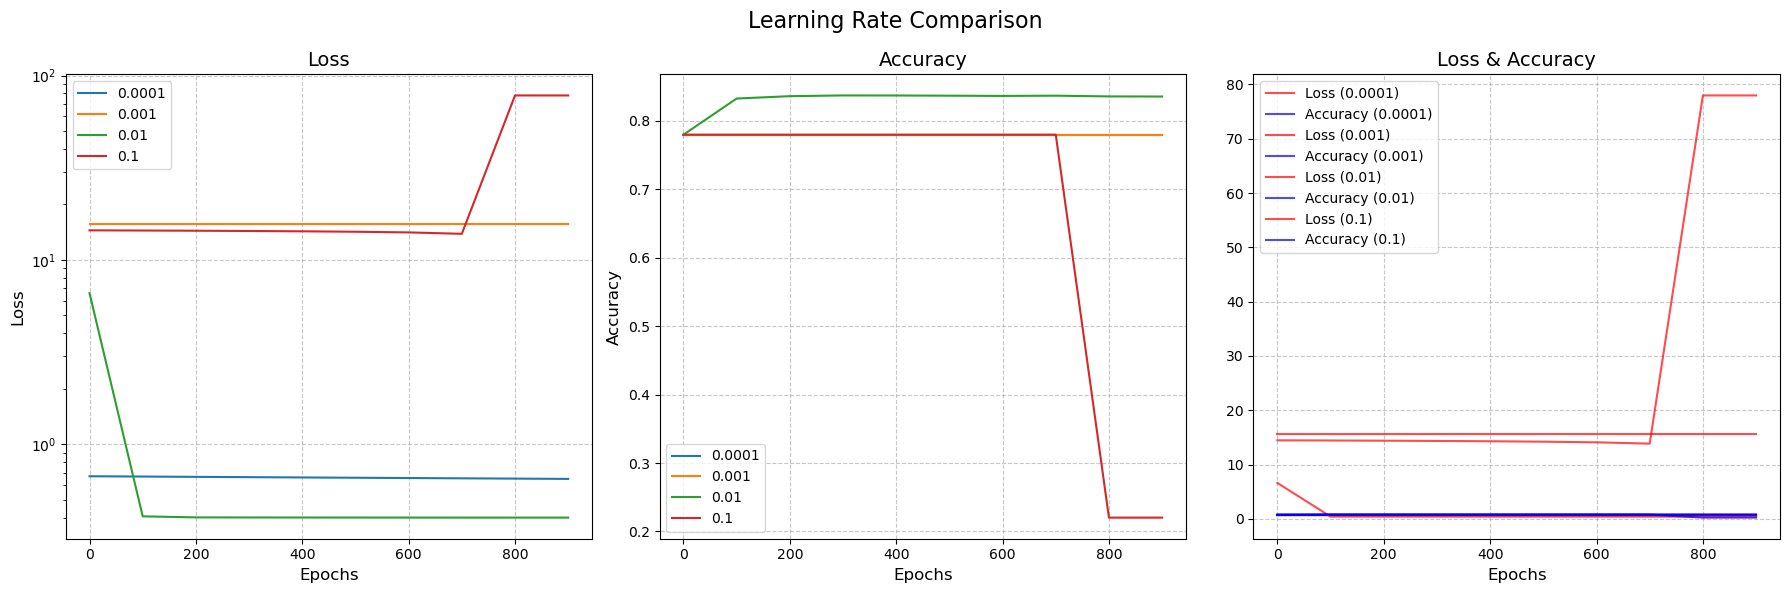

In [23]:
# 1. Learning rate
results_lr = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    # Рассчитаем потери и точности для текущего learning rate
    net = Net(n_features=X_train.shape[1], activation_fn=F.relu)
    optimizer = optim.Adam(net.parameters(), lr=lr)
    losses, accuracies = calc_by_epochs(X_train, X_test, y_train, y_test, 1000, net, optimizer)
    results_lr[lr] = {'losses': losses, 'accuracies': accuracies}
visualize_results(results_lr, title="Learning Rate Comparison")

Epoch 0, Loss: 0.7889775037765503, Accuracy: 0.2202233225107193
Epoch 100, Loss: 0.7776994705200195, Accuracy: 0.2202233225107193
Epoch 200, Loss: 0.7672679424285889, Accuracy: 0.2202233225107193
Epoch 300, Loss: 0.7570076584815979, Accuracy: 0.2202233225107193
Epoch 400, Loss: 0.7464003562927246, Accuracy: 0.2202233225107193
Epoch 500, Loss: 0.7351083755493164, Accuracy: 0.2202233225107193
Epoch 600, Loss: 0.7230110168457031, Accuracy: 0.2202233225107193
Epoch 700, Loss: 0.7102322578430176, Accuracy: 0.22917404770851135
Epoch 800, Loss: 0.6969056725502014, Accuracy: 0.4683622717857361
Epoch 900, Loss: 0.6831638216972351, Accuracy: 0.654643714427948
Epoch 0, Loss: 0.6193984746932983, Accuracy: 0.7797766923904419
Epoch 100, Loss: 0.5733209252357483, Accuracy: 0.7797766923904419
Epoch 200, Loss: 0.5130642652511597, Accuracy: 0.7797766923904419
Epoch 300, Loss: 0.4682658612728119, Accuracy: 0.8113257884979248
Epoch 400, Loss: 0.44048285484313965, Accuracy: 0.8218716979026794
Epoch 500, Lo

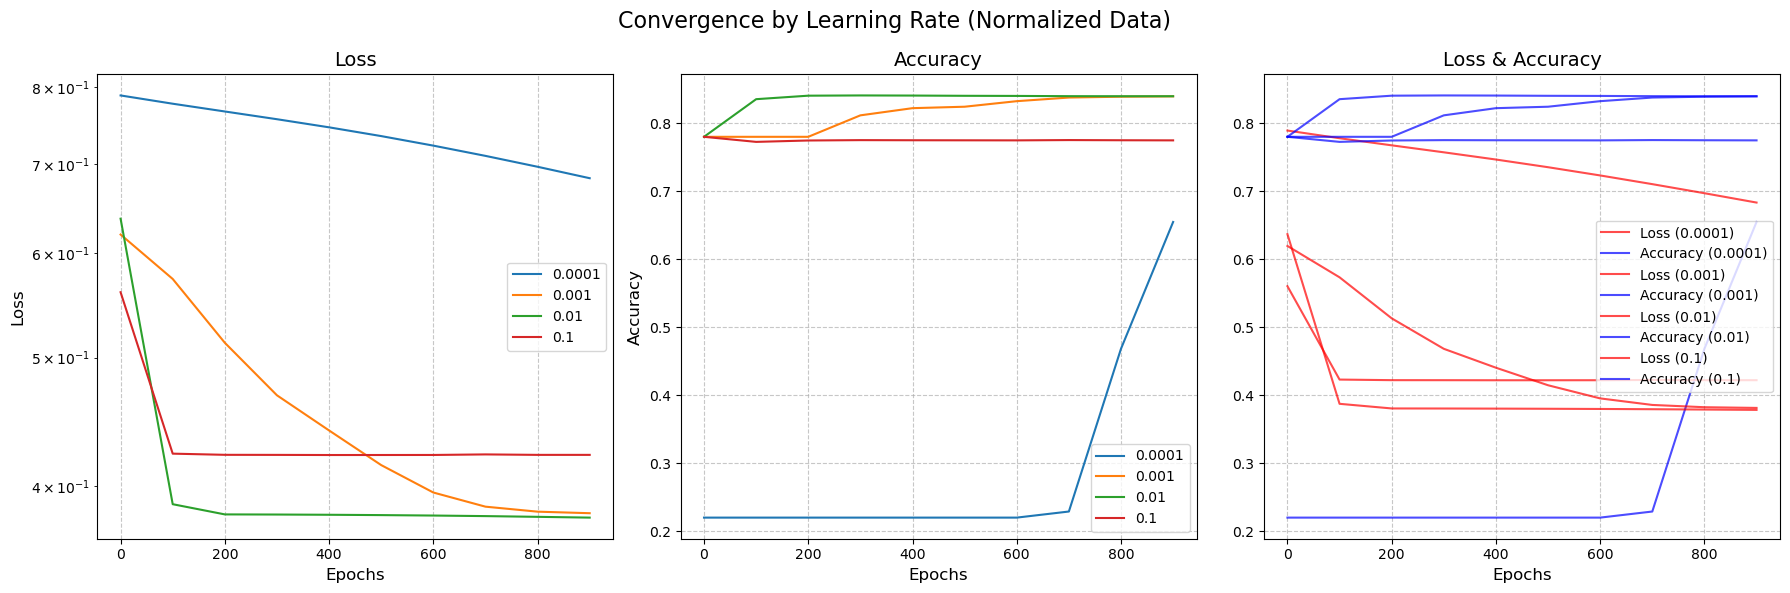

In [26]:
#2 Нормализация данных
results_norm = {}

for lr in learning_rates:
    net = Net(n_features=X_train_norm.shape[1], activation_fn=F.relu)  # Создаем модель для нормализованных данных
    optimizer = optim.Adam(net.parameters(), lr=lr)
    losses, accuracies = calc_by_epochs(X_train_norm, X_test_norm, y_train_norm, y_test_norm, 1000, net, optimizer)
    results_norm[lr] = {'losses': losses, 'accuracies': accuracies}

visualize_results(results_norm, title="Convergence by Learning Rate (Normalized Data)")

Epoch 0, Loss: 12.809211730957031, Accuracy: 0.7797766923904419
Epoch 100, Loss: 12.778403282165527, Accuracy: 0.7797766923904419
Epoch 200, Loss: 12.742769241333008, Accuracy: 0.7797766923904419
Epoch 300, Loss: 12.70044994354248, Accuracy: 0.7797766923904419
Epoch 400, Loss: 12.648360252380371, Accuracy: 0.7797766923904419
Epoch 500, Loss: 12.580708503723145, Accuracy: 0.7797766923904419
Epoch 600, Loss: 12.484369277954102, Accuracy: 0.7797766923904419
Epoch 700, Loss: 12.317340850830078, Accuracy: 0.7797766923904419
Epoch 800, Loss: 11.566187858581543, Accuracy: 0.7797766923904419
Epoch 900, Loss: 0.6174784898757935, Accuracy: 0.7797766923904419
Epoch 0, Loss: 4.715084075927734, Accuracy: 0.2202233225107193
Epoch 100, Loss: 0.7118765115737915, Accuracy: 0.2202233225107193
Epoch 200, Loss: 0.6919722557067871, Accuracy: 0.7797766923904419
Epoch 300, Loss: 0.6718809008598328, Accuracy: 0.7797766923904419
Epoch 400, Loss: 0.6529179811477661, Accuracy: 0.7797766923904419
Epoch 500, Loss:

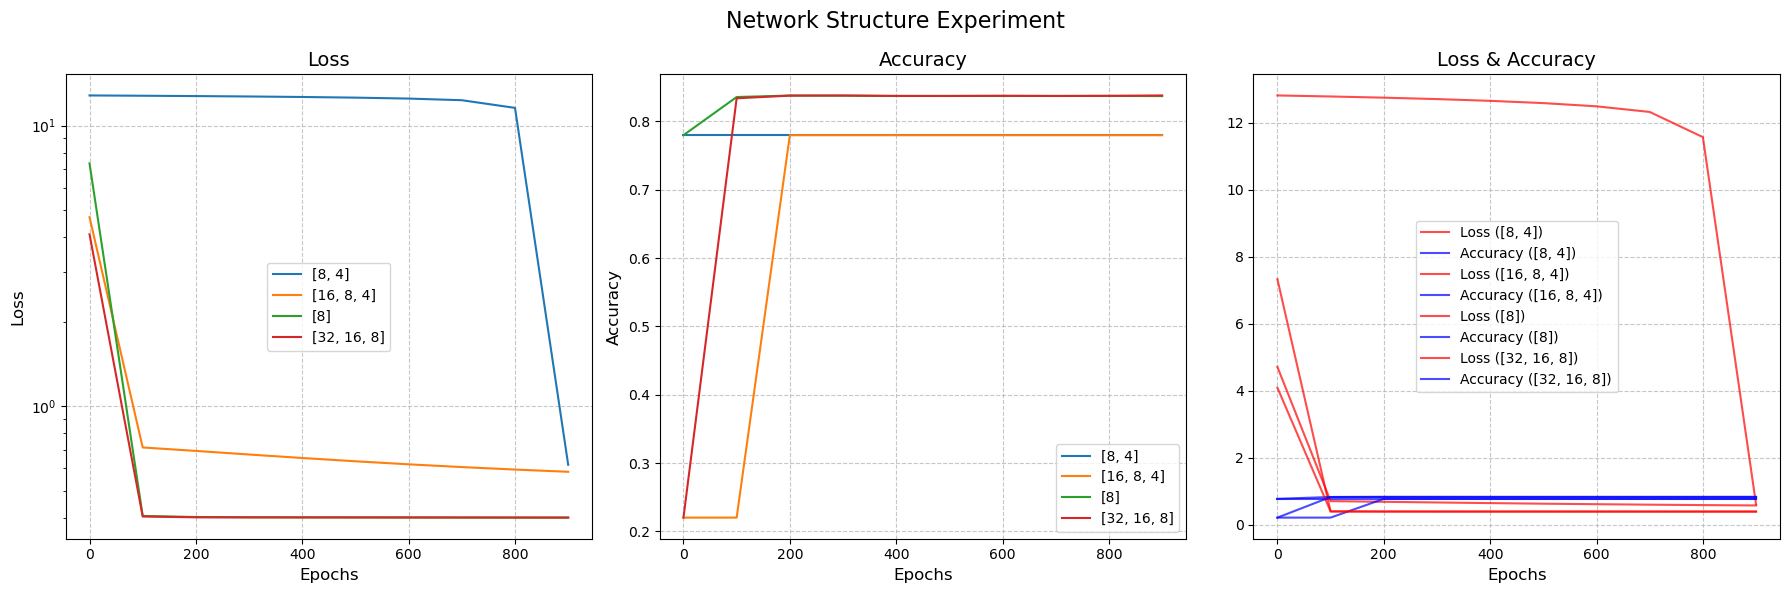

In [29]:
#3 Функция для экспериментов с различной структурой сети
def experiment_with_network_structure(X_train, X_test, y_train, y_test, hidden_layers_combinations):
    results_structure = {}

    for hidden_layers in hidden_layers_combinations:
        net = Net(n_features=X_train.shape[1], hidden_layers=hidden_layers, activation_fn=F.relu)
        optimizer = optim.Adam(net.parameters(), lr=0.001)  # Для примера используем Adam с lr=0.001
        losses, accuracies = calc_by_epochs(X_train, X_test, y_train, y_test, 1000, net, optimizer)

        results_structure[str(hidden_layers)] = {'losses': losses, 'accuracies': accuracies}

    return results_structure

# Определяем различные комбинации скрытых слоев
hidden_layers_combinations = [
    [8, 4],      # Стандартная структура
    [16, 8, 4],  # Дополнительный скрытый слой
    [8],         # Только один скрытый слой
    [32, 16, 8]  # Увеличение числа нейронов в скрытых слоях
]


results_structure = experiment_with_network_structure(X_train, X_test, y_train, y_test, hidden_layers_combinations)
visualize_results(results_structure, title="Network Structure Experiment")

Epoch 0, Loss: 1.7815889120101929, Accuracy: 0.2202233225107193
Epoch 100, Loss: 0.7275174856185913, Accuracy: 0.2202233225107193
Epoch 200, Loss: 0.7030848264694214, Accuracy: 0.2202233225107193
Epoch 300, Loss: 0.6798716187477112, Accuracy: 0.7797766923904419
Epoch 400, Loss: 0.6586963534355164, Accuracy: 0.7797766923904419
Epoch 500, Loss: 0.6397225260734558, Accuracy: 0.7797766923904419
Epoch 600, Loss: 0.6229093670845032, Accuracy: 0.7797766923904419
Epoch 700, Loss: 0.6081353425979614, Accuracy: 0.7797766923904419
Epoch 800, Loss: 0.5952445864677429, Accuracy: 0.7797766923904419
Epoch 900, Loss: 0.5840691924095154, Accuracy: 0.7797766923904419
Epoch 0, Loss: 0.8929308652877808, Accuracy: 0.2202233225107193
Epoch 100, Loss: 0.7507487535476685, Accuracy: 0.2202233225107193
Epoch 200, Loss: 0.6642202734947205, Accuracy: 0.7797766923904419
Epoch 300, Loss: 0.597545325756073, Accuracy: 0.7797766923904419
Epoch 400, Loss: 0.5626615285873413, Accuracy: 0.7797766923904419
Epoch 500, Loss

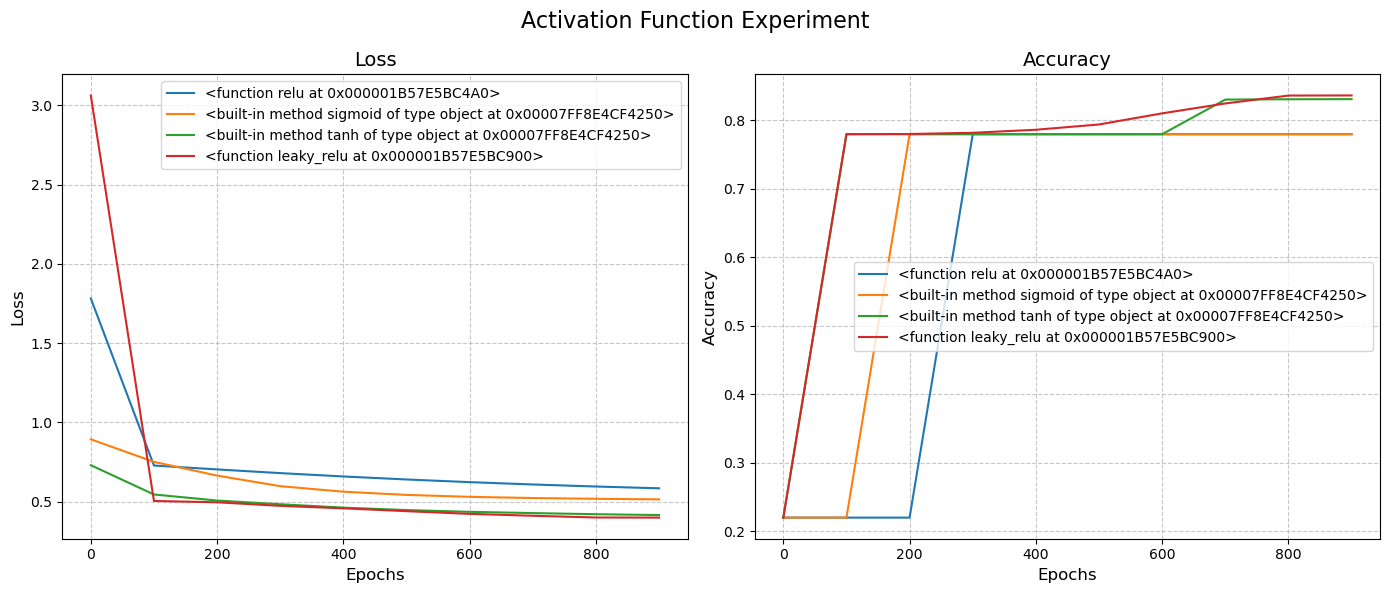

In [33]:
# 4. Эксперимент с различными функциями активации
def experiment_with_activation(X_train, X_test, y_train, y_test, activation_functions):
    results_activation = {}

    for activation_fn in activation_functions:
        net = Net(n_features=X_train.shape[1], activation_fn=activation_fn)
        optimizer = optim.Adam(net.parameters(), lr=0.001)
        losses, accuracies = calc_by_epochs(X_train, X_test, y_train, y_test, 1000, net, optimizer)

        results_activation[str(activation_fn)] = {'losses': losses, 'accuracies': accuracies}

    return results_activation

# Визуализация результатов
def visualize_results(results, title=None):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 строка, 2 столбца

    for param, metrics in results.items():
        losses = metrics["losses"]
        accuracies = metrics["accuracies"]
        epochs = range(0, len(losses) * 100, 100)
        
        # Loss plot
        axes[0].plot(epochs, losses, label=f'{param}')
        axes[0].set_title("Loss", fontsize=14)
        axes[0].set_xlabel("Epochs", fontsize=12)
        axes[0].set_ylabel("Loss", fontsize=12)
        axes[0].grid(True, linestyle="--", alpha=0.7)

        # Accuracy plot
        axes[1].plot(epochs, accuracies, label=f'{param}')
        axes[1].set_title("Accuracy", fontsize=14)
        axes[1].set_xlabel("Epochs", fontsize=12)
        axes[1].set_ylabel("Accuracy", fontsize=12)
        axes[1].grid(True, linestyle="--", alpha=0.7)

    for ax in axes:
        ax.legend(fontsize=10)
    
    if title:
        fig.suptitle(title, fontsize=16)
    
    plt.tight_layout()
    plt.show()

# Список функций активации
activation_functions = [F.relu, torch.sigmoid, torch.tanh, F.leaky_relu]

# Выполняем эксперимент
results_activation = experiment_with_activation(X_train, X_test, y_train, y_test, activation_functions)

# Визуализируем результаты
visualize_results(results_activation, title="Activation Function Experiment")


Epoch 0, Loss: 3.2023963928222656, Accuracy: 0.7797766923904419
Epoch 100, Loss: 0.5260763764381409, Accuracy: 0.7797766923904419
Epoch 200, Loss: 0.5228161811828613, Accuracy: 0.7797766923904419
Epoch 300, Loss: 0.5181502103805542, Accuracy: 0.7797766923904419
Epoch 400, Loss: 0.5111316442489624, Accuracy: 0.7799538969993591
Epoch 500, Loss: 0.50074303150177, Accuracy: 0.7803084254264832
Epoch 600, Loss: 0.5173217058181763, Accuracy: 0.7799538969993591
Epoch 700, Loss: 0.5071542263031006, Accuracy: 0.7803969979286194
Epoch 800, Loss: 0.5028906464576721, Accuracy: 0.7804856300354004
Epoch 900, Loss: 0.49866151809692383, Accuracy: 0.7804856300354004
Epoch 0, Loss: 2.6323742866516113, Accuracy: 0.2202233225107193
Epoch 100, Loss: 0.5325413942337036, Accuracy: 0.7798653244972229
Epoch 200, Loss: 0.47201773524284363, Accuracy: 0.7850939631462097
Epoch 300, Loss: 0.43737849593162537, Accuracy: 0.7973236441612244
Epoch 400, Loss: 0.41877201199531555, Accuracy: 0.8156682252883911
Epoch 500, L

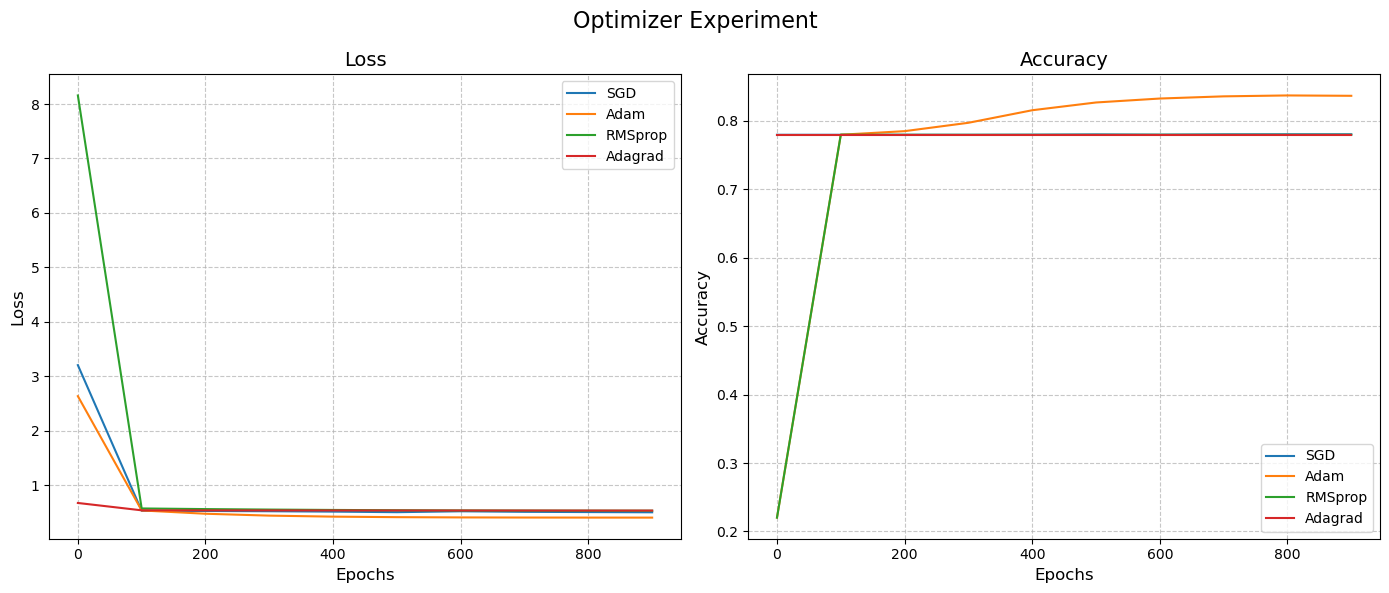

In [35]:
# 5. Эксперимент с различными методами оптимизации

def experiment_with_optimizer(X_train, X_test, y_train, y_test, optimizers):
    results_optimizer = {}

    for optimizer_name, optimizer_fn in optimizers:
        net = Net(n_features=X_train.shape[1], activation_fn=F.relu)
        optimizer = optimizer_fn(net.parameters(), lr=0.001)
        losses, accuracies = calc_by_epochs(X_train, X_test, y_train, y_test, 1000, net, optimizer)

        results_optimizer[optimizer_name] = {'losses': losses, 'accuracies': accuracies}

    return results_optimizer

# Список оптимизаторов
optimizers = [
    ('SGD', optim.SGD),
    ('Adam', optim.Adam),
    ('RMSprop', optim.RMSprop),
    ('Adagrad', optim.Adagrad)
]

# Выполняем эксперимент
results_optimizer = experiment_with_optimizer(X_train, X_test, y_train, y_test, optimizers)

# Визуализируем результаты
visualize_results(results_optimizer, title="Optimizer Experiment")


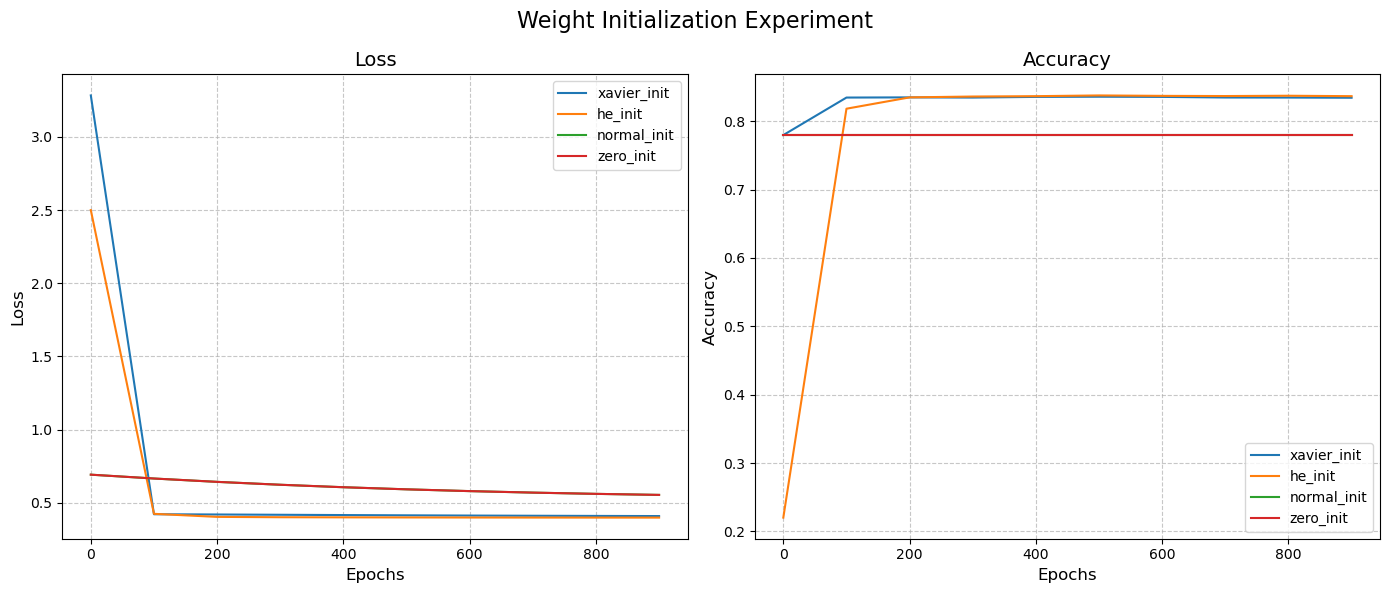

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Модель с возможностью изменения инициализации весов
class Net(nn.Module):
    def __init__(self, n_features, hidden_layers=[8, 4], activation_fn=nn.ReLU, weight_init=None):
        super(Net, self).__init__()
        layers = []
        input_size = n_features
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(input_size, hidden_size))
            
            # Используем активации как модули, а не функции
            if activation_fn == nn.ReLU:
                layers.append(nn.ReLU())
            elif activation_fn == nn.Sigmoid:
                layers.append(nn.Sigmoid())
            elif activation_fn == nn.Tanh:
                layers.append(nn.Tanh())
            elif activation_fn == nn.LeakyReLU:
                layers.append(nn.LeakyReLU())
            
            input_size = hidden_size
        
        layers.append(nn.Linear(input_size, 1))
        layers.append(nn.Sigmoid())  # Выходной слой с Sigmoid
        self.model = nn.ModuleList(layers)

        # Инициализация весов
        if weight_init:
            self.apply(weight_init)

    def forward(self, x):
        for layer in self.model:
            x = layer(x)
        return x

# Функции для инициализации весов
def xavier_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

def he_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

def normal_init(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=0.01)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

def zero_init(m):
    if isinstance(m, nn.Linear):
        nn.init.zeros_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Функция для вычисления потерь и точности по эпохам
def calc_by_epochs(X_train, X_test, y_train, y_test, num_epochs, net, optimizer, criterion=nn.BCELoss()):
    epoch_losses = []
    epoch_accuracies = []
    for epoch in range(num_epochs):
        y_pred = net(X_train).squeeze()
        train_loss = criterion(y_pred, y_train)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # Вычисление потерь и точности на тестовом наборе
        y_test_pred = net(X_test).squeeze()
        test_loss = criterion(y_test_pred, y_test)
        test_acc = (y_test_pred.ge(0.5).view(-1) == y_test).sum().float() / len(y_test)

        if epoch % 100 == 0:
            epoch_losses.append(test_loss.item())
            epoch_accuracies.append(test_acc.item())
    
    return epoch_losses, epoch_accuracies

# Эксперимент с различными методами инициализации весов
def experiment_with_weight_init(X_train, X_test, y_train, y_test, weight_init_functions):
    results_init = {}

    for init_fn in weight_init_functions:
        net = Net(n_features=X_train.shape[1], activation_fn=nn.ReLU, weight_init=init_fn)
        optimizer = optim.Adam(net.parameters(), lr=0.001)
        losses, accuracies = calc_by_epochs(X_train, X_test, y_train, y_test, 1000, net, optimizer)

        results_init[str(init_fn.__name__)] = {'losses': losses, 'accuracies': accuracies}

    return results_init

# Визуализация результатов
def visualize_results(results, title=None):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 строка, 2 столбца

    for param, metrics in results.items():
        losses = metrics["losses"]
        accuracies = metrics["accuracies"]
        epochs = range(0, len(losses) * 100, 100)
        
        # Loss plot
        axes[0].plot(epochs, losses, label=f'{param}')
        axes[0].set_title("Loss", fontsize=14)
        axes[0].set_xlabel("Epochs", fontsize=12)
        axes[0].set_ylabel("Loss", fontsize=12)
        axes[0].grid(True, linestyle="--", alpha=0.7)

        # Accuracy plot
        axes[1].plot(epochs, accuracies, label=f'{param}')
        axes[1].set_title("Accuracy", fontsize=14)
        axes[1].set_xlabel("Epochs", fontsize=12)
        axes[1].set_ylabel("Accuracy", fontsize=12)
        axes[1].grid(True, linestyle="--", alpha=0.7)

    for ax in axes:
        ax.legend(fontsize=10)
    
    if title:
        fig.suptitle(title, fontsize=16)
    
    plt.tight_layout()
    plt.show()

# Список функций инициализации весов
weight_init_functions = [xavier_init, he_init, normal_init, zero_init]

# Выполняем эксперимент
results_weight_init = experiment_with_weight_init(X_train, X_test, y_train, y_test, weight_init_functions)

# Визуализируем результаты
visualize_results(results_weight_init, title="Weight Initialization Experiment")
